LSTM
==

In [69]:
import os
from random import shuffle

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [70]:
filename= '../data/french_clean.txt'

In [98]:
def reverse_sequence(noun):
    return noun[::-1]

def pad_sequence(sequence,pad_size,pad_token):
    # returns a list of the characters in the sequence with additional pad tokens to match pad_size if needed
    return list(sequence) + [pad_token] * (pad_size - len(sequence))

def code_sequence(charseq,encodingmap,unk_token='<unk>'):
    # charseq is a sequence of chars
    return [encodingmap[char] if char in encodingmap 
            else encodingmap[unk_token] for char in charseq]

def decode_sequence(idxseq,decodingmap):
    # idxseq is a list of integers
    return [decodingmap[idx] for idx in idxseq]

In [102]:
def read_data(filename, reverse_nouns=False):
    with open(filename, 'r', encoding='utf-8') as file:
        data = [line.strip() for line in file.readlines()]

    X, y = [], []
    for pair in data:
        noun, gender = pair.split(', ')
        if reverse_nouns:
            noun = reverse_sequence(noun)
        noun_chars = [char for char in noun] # split the nouns into characters
        X.append(noun_chars)
        y.append(gender)
    
    return X, y

In [114]:
def vocabulary(filename, labels=False, pad_token='<pad>', unk_token='<unk>'):
    
    nouns, genders = read_data(filename, reverse_nouns=False)
    
    if labels:
        sym2idx = {sym: idx for idx, sym in enumerate(set(genders))}
    else:
        unique_chars = set(char for noun in nouns for char in noun)
        sym2idx = {sym: idx for idx, sym in enumerate(unique_chars)}
        sym2idx[unk_token] = len(sym2idx)
        sym2idx[pad_token] = len(sym2idx)

    idx2sym = [sym for sym in sym2idx.keys()]

    return idx2sym, sym2idx

In [74]:
def save_padded_words(filename, batch_of_words):
    lines = ['\t'.join(word) + '\n' for word in batch_of_words]
    with open(filename, 'a', encoding='utf-8') as f:
        f.writelines(lines)

In [127]:
# Inspiration from code by Benoit Crabbé
class DataGenerator:

      def __init__(self, filename, reverse_nouns=False, pad_token='<pad>', unk_token='<unk>'):

          self.pad_token = pad_token
          self.unk_token = unk_token

          self.input_idx2sym,self.input_sym2idx   = vocabulary(filename,False)
          self.output_idx2sym,self.output_sym2idx = vocabulary(filename,True)

          nouns, genders = read_data(filename, reverse_nouns=reverse_nouns)
          self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(nouns, genders, test_size=0.2)

          self.train_size = len(self.X_train)
          self.test_size = len(self.X_test)

      def generate_batches(self,batch_size,validation=False):

          if validation:
              X = self.X_test
              y = self.y_test
          else:
              X = self.X_train
              y = self.y_train

          assert(len(X) == len(y))

          N     = len(X)
          idxes = list(range(N))

          # Data ordering
          shuffle(idxes)
          idxes.sort(key=lambda idx: len(X[idx]))

          # batch generation
          bstart = 0
          while bstart < N:
              bend        = min(bstart+batch_size,N)
              batch_idxes = idxes[bstart:bend]
              batch_len   = max(len(X[idx]) for idx in batch_idxes)
              Xpad        = [pad_sequence(X[idx],batch_len,self.pad_token) for idx in batch_idxes]
            #   save_padded_words('../data/eval/padded_fr', Xpad)
              seqX        = [code_sequence(x,self.input_sym2idx,self.unk_token) for x in Xpad]
              seqY        = [self.output_sym2idx[y[idx]] for idx in batch_idxes]

              assert(len(seqX) == len(seqY))
              yield (seqX,seqY)
              bstart += batch_size

Model
==

Train the model by feeding it words in reverse order (since we want to start from the end of the word) and the corresponding genders. The model will learn to predict the gender based on the characters seen so far.

Takes preprocessed words as input:
- tokenized into characters 
- each character mapped to a unique integer id (same with each gender)
- sequences should be padded so they all have the same length

In [76]:
# # second version:
# class GenderLSTM(nn.Module):

#     def __init__(self, datagenerator, embedding_dim, hidden_dim, device='cpu'):
#         super(GenderLSTM, self).__init__()
#         self.to(device)

#         invocab_size = len(datagenerator.input_idx2sym)
#         outvocab_size = len(datagenerator.output_idx2sym)

#         self.device = torch.device(device)
#         self.pad_idx = datagenerator.input_sym2idx[datagenerator.pad_token]
#         self.embedding = nn.Embedding(invocab_size, embedding_dim)
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, outvocab_size)


#     def forward(self, inputs):
#         embeds = self.embedding(inputs) # shape: [batch_size, sequence_length, embedding_dim]
        
#         # the hidden state for the last time step in the input sequence for each element in the batch. 
#         _, (hidden, _) = self.lstm(embeds)  # Shape: [num_layers(* num_directions which is 1 here), batch_size, hidden_size]
        
#         #  sending the last hidden state of the last layer (hidden[-1]) through the fully-connected network
#         hidden_logits = self.fc(hidden[-1]) # shape: [batch_size, num_classes]

#         return hidden_logits  


#     def train_model(self, datagenerator, n_epochs, batch_size, learning_rate=0.001):
#         criterion = nn.CrossEntropyLoss(ignore_index=self.pad_idx)
#         optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
#         self.avg_train_accuracies = []
#         self.avg_valid_accuracies = []
#         self.avg_train_losses = []
#         self.avg_valid_losses = []

#         max_val_acc = 0
#         patience = 3
#         counter = 0
        
#         for epoch in range(n_epochs):
#             print(f'Epoch: {epoch}')
#             epoch_train_accuracies = [] 
#             epoch_valid_accuracies = []
#             epoch_train_losses = []
#             epoch_valid_losses = []
            
#             # Training phase
#             self.train()
#             for inputs, labels in datagenerator.generate_batches(batch_size):
#                 X = torch.LongTensor(inputs).to(self.device) # shape: [batch_size, sequence_length]
#                 Y = torch.LongTensor(labels).to(self.device) # shape: [batch_size]

#                 optimizer.zero_grad()
#                 Y_logits = self.forward(X)    # shapes: [batch_size, num_classes]

#                 # Accuracy
#                 Y_pred = torch.argmax(Y_logits, dim=-1)  # shape: [batch_size]
#                 correct = (Y_pred == Y)
#                 avg_batch_accuracy = correct.float().mean()  # scalar
#                 epoch_train_accuracies.append(avg_batch_accuracy)

#                 # Loss
#                 loss = criterion(Y_logits, Y)
#                 loss.backward()
#                 optimizer.step()
#                 epoch_train_losses.append(loss.item())

#             # Validation phase
#             self.eval()
#             for val_inputs, val_labels in datagenerator.generate_batches(batch_size, validation=True):
#                 with torch.no_grad():
#                     X_val = torch.LongTensor(val_inputs).to(self.device)
#                     Y_val = torch.LongTensor(val_labels).to(self.device)

#                     Y_val_logits = self.forward(X_val)

#                     # Accuracy
#                     Y_pred = torch.argmax(Y_val_logits, dim=-1)  # shape: [batch_size]
#                     correct = (Y_pred == Y_val)
#                     avg_batch_accuracy = correct.float().mean()  # scalar
#                     epoch_valid_accuracies.append(avg_batch_accuracy)

#                     # Loss
#                     loss = criterion(Y_val_logits, Y_val)
#                     epoch_valid_losses.append(loss.item()) 


#             # store & report metrics at the end of each epoch
#             avg_train_accuracy = sum(epoch_train_accuracies) / len(epoch_train_accuracies)
#             avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)           
#             avg_valid_accuracy = sum(epoch_valid_accuracies) / len(epoch_valid_accuracies)
#             avg_valid_loss = sum(epoch_valid_losses) / len(epoch_valid_losses)
            
#             self.avg_train_accuracies.append(avg_train_accuracy)
#             self.avg_train_losses.append(avg_train_loss)
#             self.avg_valid_accuracies.append(avg_valid_accuracy)
#             self.avg_valid_losses.append(avg_valid_loss)

#             print(f'[Train] Loss: {avg_train_loss * 100:.2f}%   Accuracy: {avg_train_accuracy * 100:.2f}%')      
#             print(f'[Valid] Loss: {avg_valid_loss * 100:.2f}%   Accuracy: {avg_valid_accuracy * 100:.2f}%')
#             print('-' * 100)

#             # checking for early stopping
#             if avg_valid_accuracy > max_val_acc:
#                 max_val_acc = avg_valid_accuracy
#                 counter = 0
#             else:
#                 counter += 1

#             if counter == patience:
#                 print(f'Early stopping after {epoch + 1} epochs and {patience} epochs without improvement.')
#                 break


#     def predict(self, datagenerator, batch_size):
#         predictions = {'Word': [], 'Predicted Gender': [], 'True Gender': []}
        
#         self.eval()
#         for inputs, labels in datagenerator.generate_batches(batch_size, validation=True):
#             with torch.no_grad():
#                 X = torch.LongTensor(inputs).to(self.device)
#                 Y = torch.LongTensor(labels).to(self.device)

#                 logits = self.forward(X)
#                 Y_pred = torch.argmax(logits, dim=-1)

#                 # converting the predictions into readable format
#                 pad_idx = datagenerator.input_sym2idx[datagenerator.pad_token]
#                 for i in range(len(X)):
#                     predictions['Word'].append(''.join([datagenerator.input_idx2sym[idx] for idx in X[i] if idx != pad_idx]))
#                     predictions['Predicted Gender'].append(''.join([datagenerator.output_idx2sym[Y[i]]]))
#                     predictions['True Gender'].append(''.join([datagenerator.output_idx2sym[Y_pred[i]]]))
        
#         return predictions


In [131]:
# Third version:
class GenderLSTM(nn.Module):

    def __init__(self, datagenerator, embedding_dim, hidden_dim, device='cpu'):
        super(GenderLSTM, self).__init__()
        self.to(device)

        invocab_size = len(datagenerator.input_idx2sym)
        outvocab_size = len(datagenerator.output_idx2sym)

        self.device = torch.device(device)
        self.pad_idx = datagenerator.input_sym2idx[datagenerator.pad_token]
        self.embedding = nn.Embedding(invocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, outvocab_size)
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, inputs):
        embeds = self.embedding(inputs)
        
        # lstm_out contains the hidden states for each time step in the input sequence for each element in the batch. Shape: [batch_size, sequence_length, hidden_size]
        # hidden is the hidden state for the last time step in the input sequence for each element in the batch. Shape: [num_layers(* num_directions which is 1 here), batch_size, hidden_size]
        lstm_out, (hidden, _) = self.lstm(embeds)   
        
        out_logits = self.fc(lstm_out)   # shape: [batch_size, sequence_length, num_classes] --> these will be used to get accuracy values for each time step
        
        #  taking the last hidden state of the last layer with hidden[-1]
        hidden_logits = self.fc(hidden[-1]) # shape: [batch_size, num_classes]  --> these will be used for loss computation

        # add softmax to get probability distributions (for easier interpretability)
        out_probabilities = self.softmax(out_logits)   # probability distribution over the classes for each character in the sequence 
        # it would also be a good idea to calibrate the model (dividing c by a value T (tempreture) that is a hyperparameter that can be tuned --> ask Timothee)
        return out_probabilities, hidden_logits  


    def train_model(self, datagenerator, n_epochs, batch_size, learning_rate=0.001):
        criterion = nn.CrossEntropyLoss(ignore_index=self.pad_idx)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        train = {'accuracy': [],
                 'loss': [],
                 'plateau_beg': [], 
                 'acc_at_plateau_beg': []
                 }
            
        valid = {'accuracy': [],
                 'loss': [],
                 'plateau_beg': [], 
                 'acc_at_plateau_beg': []
                 }

        max_val_acc = 0
        patience = 3
        counter = 0
        
        for epoch in range(n_epochs):
            print(f'Epoch: {epoch}')
            epoch_train_accuracies = [] 
            epoch_valid_accuracies = []
            epoch_train_losses = []
            epoch_valid_losses = []
            train_plateau_indecies = [] # will contain the index of the position at which the accuracy starts to plateau for each batch
            valid_plateau_indecies = []
            train_plateau_accuracies = []   # will contain the accuracy of the position at which the accuracy starts to plateau for each batch
            valid_plateau_accuracies = []
            
            # Training phase
            self.train()
            for inputs, labels in datagenerator.generate_batches(batch_size):
                X = torch.LongTensor(inputs).to(self.device) # shape: [batch_size, sequence_length]
                Y = torch.LongTensor(labels).to(self.device) # shape: [batch_size]

                optimizer.zero_grad()
                Y_seq_probs, Y_hidden_logits = self.forward(X)    # shapes: [batch_size, sequence_length, num_classes], [batch_size, num_classes]

                # Loss
                loss = criterion(Y_hidden_logits, Y)
                loss.backward()
                optimizer.step()
                epoch_train_losses.append(loss.item())

                # Accuracy
                Y_pred = torch.argmax(Y_hidden_logits, dim=-1)  # shape: [batch_size]
                correct = (Y_pred == Y)
                avg_batch_accuracy = correct.float().mean()  # scalar
                epoch_train_accuracies.append(avg_batch_accuracy)

                # Accuracies for all character positions
                plateau_position, plateau_accuracy = self.get_plateau_info(Y_seq_probs, Y, threshold=0.01, patience=3) 
                train_plateau_indecies.append(plateau_position)
                train_plateau_accuracies.append(plateau_accuracy)

            # Validation phase
            self.eval()
            for val_inputs, val_labels in datagenerator.generate_batches(batch_size, validation=True):
                with torch.no_grad():
                    X_val = torch.LongTensor(val_inputs).to(self.device)
                    Y_val = torch.LongTensor(val_labels).to(self.device)

                    Y_val_seq_probs, Y_val_hidden_logits = self.forward(X_val)

                    # Loss
                    loss = criterion(Y_val_hidden_logits, Y_val)
                    epoch_valid_losses.append(loss.item())

                    # Accuracy
                    Y_pred = torch.argmax(Y_val_hidden_logits, dim=-1)  # shape: [batch_size]
                    correct = (Y_pred == Y_val)
                    avg_batch_accuracy = correct.float().mean()  # scalar
                    epoch_valid_accuracies.append(avg_batch_accuracy)

                    # Accuracies for all character positions
                    plateau_position, plateau_accuracy = self.get_plateau_info(Y_val_seq_probs, Y_val, threshold=0.01, patience=3) 
                    valid_plateau_indecies.append(plateau_position)
                    valid_plateau_accuracies.append(plateau_accuracy) 


            # store & report metrics at the end of each epoch
            avg_train_accuracy = sum(epoch_train_accuracies) / len(epoch_train_accuracies)
            avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)  
            train_plateau_beg = max(set(train_plateau_indecies), key=train_plateau_indecies.count)  # should I get the one that appears the most or the average?
            train_acc_at_plateau_beg = train_plateau_accuracies[train_plateau_beg]                    
            
            avg_valid_accuracy = sum(epoch_valid_accuracies) / len(epoch_valid_accuracies)
            avg_valid_loss = sum(epoch_valid_losses) / len(epoch_valid_losses)
            valid_plateau_beg = max(set(valid_plateau_indecies), key=valid_plateau_indecies.count)
            valid_acc_at_plateau_beg = valid_plateau_accuracies[valid_plateau_beg]

            train['accuracy'].append(avg_train_accuracy)
            train['loss'].append(avg_train_loss)
            train['plateau_beg'].append(train_plateau_beg)
            train['acc_at_plateau_beg'].append(train_acc_at_plateau_beg)
            
            valid['accuracy'].append(avg_valid_accuracy)
            valid['loss'].append(avg_valid_loss)
            valid['plateau_beg'].append(valid_plateau_beg)
            valid['acc_at_plateau_beg'].append(valid_acc_at_plateau_beg)

            print(f'[Train] Loss: {avg_train_loss:.4f}   Accuracy: {avg_train_accuracy * 100:.2f}%   Beginning of plateau (index): {train_plateau_beg}   Accuracy at the beginning of plateau: {train_acc_at_plateau_beg * 100:.2f}%')      
            print(f'[Valid] Loss: {avg_valid_loss:.4f}   Accuracy: {avg_valid_accuracy * 100:.2f}%   Beginning of plateau (index): {valid_plateau_beg}   Accuracy at the beginning of plateau: {valid_acc_at_plateau_beg * 100:.2f}%')
            print('-' * 100)

            # checking for early stopping
            if avg_valid_accuracy > max_val_acc:
                max_val_acc = avg_valid_accuracy
                counter = 0
            else:
                counter += 1

            if counter == patience:
                print(f'Early stopping after {epoch + 1} epochs and {patience} epochs without improvement.')
                break

        return train, valid


    def predict(self, datagenerator, batch_size):
        predictions = {'Word': [], 'Predicted Gender': [], 'True Gender': []}
        
        self.eval()
        for inputs, labels in datagenerator.generate_batches(batch_size, validation=True):
            with torch.no_grad():
                X = torch.LongTensor(inputs).to(self.device)
                Y = torch.LongTensor(labels).to(self.device)

                _, logits = self.forward(X)
                Y_pred = torch.argmax(logits, dim=-1)

                # converting the predictions into readable format
                pad_idx = datagenerator.input_sym2idx[datagenerator.pad_token]
                for i in range(len(X)):
                    predictions['Word'].append(''.join([datagenerator.input_idx2sym[idx] for idx in X[i] if idx != pad_idx]))
                    predictions['Predicted Gender'].append(''.join([datagenerator.output_idx2sym[Y[i]]]))
                    predictions['True Gender'].append(''.join([datagenerator.output_idx2sym[Y_pred[i]]]))
        
        return predictions


    def get_plateau_info(self, Y_probs, Y, threshold=0.01, patience=3):
        Y_pred = torch.argmax(Y_probs, dim=-1)  # shape: [batch_size, sequence_length]
        correct = (Y_pred == Y.unsqueeze(-1))
        avg_pos_accuracy = correct.float().mean(dim=0)

        # if the accuracy doesn't increase by a value higher than the threshold for patience consecutive characters, extract the index and accuracy of the initial position
        # print(avg_pos_accuracy)
        counter = 0
        for position, accuracy in enumerate(avg_pos_accuracy):
            if position == 0: 
                continue
            elif accuracy - avg_pos_accuracy[position - 1] >= threshold:
                counter = 0
            elif accuracy - avg_pos_accuracy[position - 1] < threshold:
                counter += 1

            if counter == patience:
                plateau_position = position - patience
                plateau_accuracy = avg_pos_accuracy[position - patience]
                return plateau_position, plateau_accuracy

        # if there is no plateau, returns the position and accuracy of the last character
        return len(avg_pos_accuracy)-1, avg_pos_accuracy[-1]
    

In [78]:
def baseline_accuracy(datagenerator, verbose=False):
    _, train_labels = list(*datagenerator.generate_batches(datagenerator.train_size, validation=False))
    most_frequent_label = max(set(train_labels), key=train_labels.count)   
    
    if verbose:
        print(f'The most frequent label in the dataset is: {datagenerator.output_idx2sym[most_frequent_label]}')

    dev_labels = list(*datagenerator.generate_batches(datagenerator.test_size, validation=True))[1]
    return dev_labels.count(most_frequent_label) / len(dev_labels)

In [79]:
# def plot(train_acc, valid_acc, train_losses, valid_losses, train_max_indices, dev_max_indices):
def plot_metrics(train_acc, valid_acc, train_losses, valid_losses):

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
    plt.subplots_adjust(hspace=0.5)

    n_epochs = range(1, len(valid_losses) + 1)

    # Plot accuracy
    ax1.set_title('Accuracy Evolution Over Epochs')
    ax1.plot(n_epochs, train_acc, marker='o', color='steelblue', label='Training Accuracy')
    ax1.plot(n_epochs, valid_acc, marker='o', color='orange', label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, linestyle='--')

    # Plot loss
    ax2.set_title('Loss Evolution Over Epochs')
    ax2.plot(n_epochs, train_losses, marker='o', color='steelblue', label='Training Loss')
    ax2.plot(n_epochs, valid_losses, marker='o', color='orange', label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, linestyle='--')

    # Plot max indices
    # bar_width = 0.3
    # ax3.set_title('Character position (index) with the highest average accuracy at each epoch')
    # ax3.bar([i-bar_width/2 for i in n_epochs], train_max_indices, color='steelblue', width=bar_width, label='Training Set')
    # ax3.bar([i+bar_width/2 for i in n_epochs], dev_max_indices, color='orange', width=bar_width, label='Validation Set')
    # ax3.set_xlabel('Epochs')
    # ax3.set_ylabel('Indices')
    # ax3.legend()
    # ax3.grid(True, linestyle='--')

    plt.show()

In [80]:
def compare_accuracies(baseline_acc, model_acc):
    
    x_labels = ['Baseline', 'Model']
    bar_colors = ['#FFDFD3', '#593e67'] # '#957DAD'
    bars = plt.bar(x_labels, [baseline_acc, model_acc], width=0.3, color=bar_colors)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

    plt.title('Comparison Between Model Accuracy and Baseline Accuracy (= Most Frequent Class)')
    plt.ylabel('Accuracy')
    plt.grid(linestyle='dashed')
    ax = plt.gca()
    ax.set_axisbelow(True)

    plt.show()

In [132]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 128
hidden_size = 128
n_epochs = 20
batch_size = 64

data_generator = DataGenerator(filename, reverse_nouns=True)
model = GenderLSTM(data_generator, embedding_dim, hidden_size, device=DEVICE)
train, valid = model.train_model(data_generator, n_epochs, batch_size)

Epoch: 0
[Train] Loss: 0.3466   Accuracy: 85.03%   Beginning of plateau (index): 6   Accuracy at the beginning of plateau: 64.06%
[Valid] Loss: 0.3805   Accuracy: 84.08%   Beginning of plateau (index): 7   Accuracy at the beginning of plateau: 73.44%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.2829   Accuracy: 88.59%   Beginning of plateau (index): 5   Accuracy at the beginning of plateau: 75.00%
[Valid] Loss: 0.3206   Accuracy: 86.71%   Beginning of plateau (index): 5   Accuracy at the beginning of plateau: 73.44%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.2668   Accuracy: 89.42%   Beginning of plateau (index): 5   Accuracy at the beginning of plateau: 75.00%
[Valid] Loss: 0.3208   Accuracy: 86.46%   Beginning of plateau (index): 5   Accuracy at the beginning of plateau: 78.12%
---------------------------------------------

In [133]:
predictions = model.predict(data_generator, batch_size)
predictions_df = pd.DataFrame(predictions)
predictions_df

,Word,Predicted Gender,True Gender
0,e,masculine,feminine
1,x,masculine,feminine
2,éc,masculine,masculine
3,hr,feminine,masculine
4,éd,masculine,masculine
...,...,...,...
9459,erdèacédodacédodibmohr,masculine,masculine
9460,etamabracoihtidlyhtéid,masculine,masculine
9461,etanofluslyhtémoroulfirt,masculine,masculine
9462,enèidatnepolcycorolhcaxeh,masculine,masculine


In [ ]:
# # toy example
# x = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], [1.0, 2.0, 3.0, 4.0, 5.0, 0.0, 0.0], [1.0, 2.0, 3.0, 4.0, 0.0, 0.0, 0.0]])

# mask = x != 0.0

# # dividing the sum of non-zero elements for each column by the total number of non-zero elements for each column
# # mean = (x * mask).sum(dim=0) / mask.sum(dim=0)

# # dividing the sum of all elements for each column by the total number of elements for each column (not excluding 0s)
# mean = x.sum(dim=0) / len(x)

# print(f'original tensor:\n{x}\n')
# print(f'sum of the values in each column:\n{x.sum(dim=0)}\n')
# print(f'number of words in the batch (batch_size): {len(x)}\n')
# print(f'average character accuracy:\n{mean}')

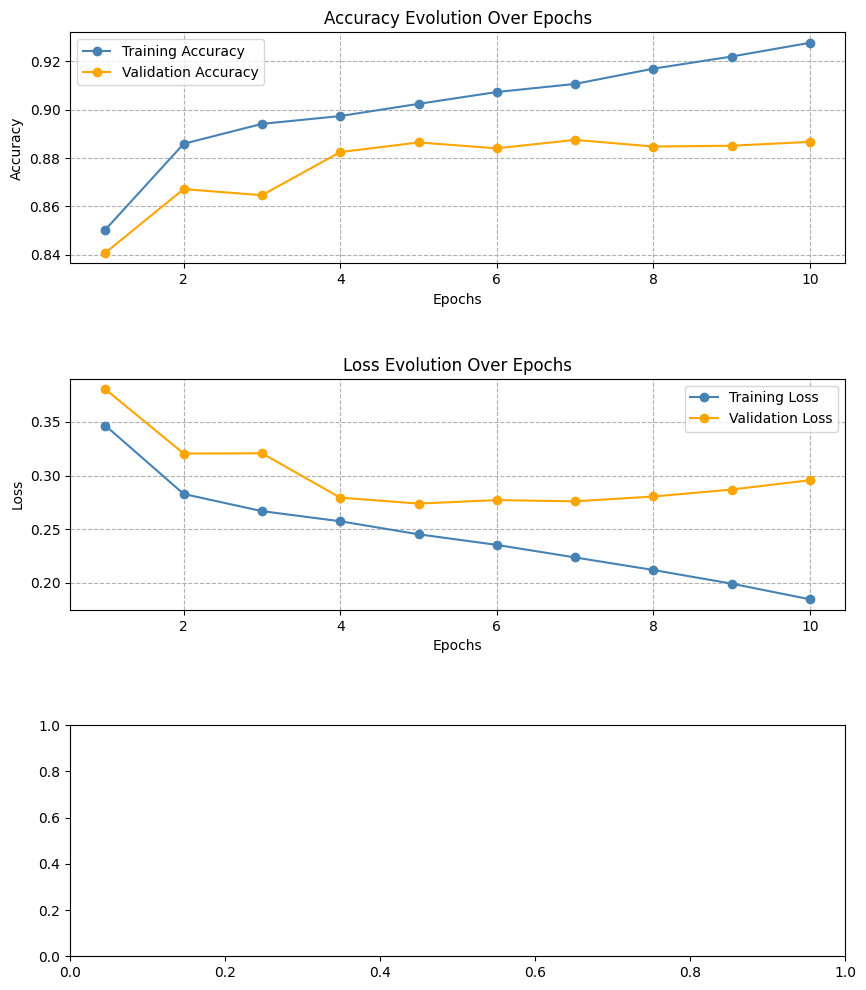

In [134]:
# plot(model.train_max_accuracies, model.valid_max_accuracies, model.avg_train_losses, model.avg_valid_losses, model.train_max_indecies, model.valid_max_indecies)
plot_metrics(train['accuracy'], valid['accuracy'], train['loss'], valid['loss'])

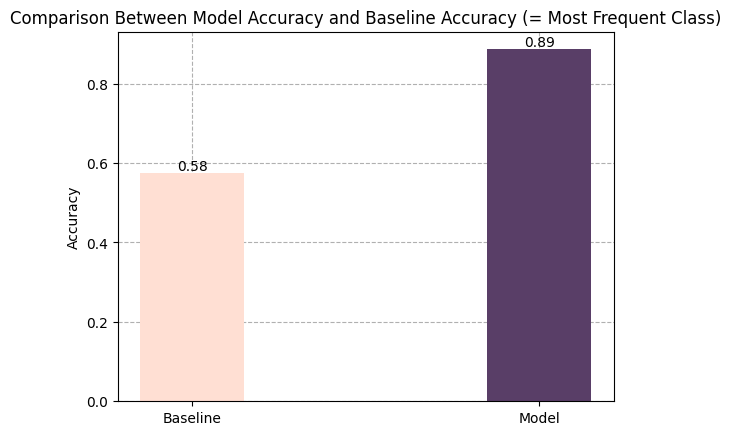

In [135]:
baseline_acc = baseline_accuracy(data_generator)

compare_accuracies(baseline_acc, valid['accuracy'][-1])

In [ ]:
# train_all_char_accuracies = [tensor.tolist() for tensor in model.train_all_char_accuracies]
# train_char_accuracies = pd.DataFrame(train_all_char_accuracies).rename_axis('epochs')
# train_char_accuracies

In [ ]:
# valid_all_char_accuracies = [tensor.tolist() for tensor in model.valid_all_char_accuracies]
# valid_char_accuracies = pd.DataFrame(valid_all_char_accuracies).rename_axis('epochs')
# valid_char_accuracies